## APPLICATIONS: TOY EXAMPLES Regression

This is not space science

In [80]:
%matplotlib inline

from fann2 import libfann # the neural network library

import numpy as np
import pandas as pd
import scipy as sp
import random
from time import time
from math import pi, sin, cos, sqrt
import scipy
from scipy.stats import pearsonr

# for the visualization:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rc
rc('mathtext', default='regular')

As our first toy example, we consider a simple regression problem. We generate 200 points randomly in the range $x ∈ [−5π, 5π]$, for which we evaluate the ramped sinc function, $$y(x)=\frac{sin(x)}{x} +0.04x,$$

https://www.overleaf.com

In [81]:
def yx(x):
    return (sin(x) / x) + 0.04 * x

def generate_data(ff, points, min, max):
    x = []
    y = []
    step = (max - min) / points
    for i in range(points):
        x.append([min])
        y.append([ff(min)])
        min = min + step
    return (x, y)

def generate_random_data(ff, points, min, max):
    """
    We generate N points randomly in the range x
    """
    x = []
    y = []
    for i in range(points):
        r = random.uniform(min, max)
        x.append([r])
        y.append([ff(r)])
    return (x, y)

def gaussian_noise(x, v):
    """
    Gaussian noise with zero mean and a standard deviation
    of 0.05. The addition of noise makes the regression problem
    more difficult and prevents any exact solution being possible.
    """
    new_x = []
    for i in range(len(x)):
        new_x.append([x[i][0] + random.uniform(-v, v)])
    return new_x

In [82]:
def divided_randomly_training_validation(input_data, target_data):
    """
    To perform the regression, the N data items (x, y) are divided
    randomly into 70% items for training and 30% for validation.
    """
    len_data = len(input_data)
    p = int((len_data * 70) / 100)
    #print(p)
    input_data_train = input_data[:p]
    target_data_train = target_data[:p]
    input_data_test = input_data[p:]
    target_data_test = target_data[p:]
    return (input_data_train, target_data_train, input_data_test, target_data_test)

In [83]:
input_data, target_data = generate_random_data(yx, 200, -5. * pi, 5. * pi)
noise_target_data = gaussian_noise(target_data, 0.05)

input_data_train, target_data_train, input_data_test, target_data_test = \
    divided_randomly_training_validation(input_data, noise_target_data)

train_data = libfann.training_data()
test_data = libfann.training_data()

train_data.set_train_data(input_data_train, target_data_train)
train_data.save_train("sin.train")

test_data.set_train_data(input_data_test, target_data_test)
test_data.save_train("sin.test")

True

In [84]:
mse_list = []
correlation_list = []
nn_architecture = []
ann_list = []
n_hide = []

for i in range(21):
    nn_architecture.append([1, i+1, 1])
    n_hide.append(i+1)

print(nn_architecture)

[[1, 1, 1], [1, 2, 1], [1, 3, 1], [1, 4, 1], [1, 5, 1], [1, 6, 1], [1, 7, 1], [1, 8, 1], [1, 9, 1], [1, 10, 1], [1, 11, 1], [1, 12, 1], [1, 13, 1], [1, 14, 1], [1, 15, 1], [1, 16, 1], [1, 17, 1], [1, 18, 1], [1, 19, 1], [1, 20, 1], [1, 21, 1]]


In [85]:
# On Predicting the Optimal Number of Hidden Nodes
for i in range(21):    
    t0 = time()
    mse_tmp = []
    ann_tmp = []
    for j in range(30): # networks for each topology between
        ann = libfann.neural_net()
        ann.create_standard_array(nn_architecture[i])

        ann.set_learning_rate(0.7)
        ann.set_learning_momentum(0.5)
        ann.randomize_weights(-0.1, 0.1)
        ann.init_weights(train_data)
        ann.set_activation_function_output(libfann.SIGMOID_SYMMETRIC_STEPWISE)
        ann.set_activation_function_output(libfann.LINEAR)
        #ann.set_activation_function_output(libfann.SIGMOID_SYMMETRIC_STEPWISE)
        max_iterations = 1000
        iterations_between_reports =  200
        # Optimum MSE(mean squared error) for neural networks
        desired_error =  0.005
        
        ann.train_on_data(train_data, max_iterations, iterations_between_reports, desired_error)
        ann_tmp.append(ann)
        mse_tmp.append(ann.get_MSE())
        #ann.save("sin_float-" + str(i+1) + "-" + str(j+1) + ".net")
    run_test = []
    diff_test = []
    for idx in range(len(input_data_test)):
        run_test.append(ann_tmp[mse_tmp.index(min(mse_tmp))].run([input_data_test[idx][0]]))
    for idx in range(len(input_data_test)):
        diff_test.append(target_data_test[idx][0] - run_test[idx][0])
    
    ann_list.append(ann_tmp[mse_tmp.index(min(mse_tmp))])
    mse_list.append(min(mse_tmp))
    correlation_list.append(pearsonr(target_data_test, run_test)[0])
    
    ann.save("sin_float-" + str(i + 1) + ".net")
    t1 = time()
    print(nn_architecture[i], " minMSE = %7f" %min(mse_tmp), mse_tmp.index(min(mse_tmp)), \
       "pearsonr = %7f" %pearsonr(target_data_test, run_test)[0][0], 'times: %7f s' %(t1-t0))       
print("Done.")        

[1, 1, 1]  minMSE = 0.070442 1 pearsonr = 0.672837 times: 1.878386 s
[1, 2, 1]  minMSE = 0.054731 11 pearsonr = 0.701879 times: 2.307196 s
[1, 3, 1]  minMSE = 0.052858 2 pearsonr = 0.873685 times: 2.772314 s
[1, 4, 1]  minMSE = 0.047676 22 pearsonr = 0.854568 times: 3.235603 s
[1, 5, 1]  minMSE = 0.012920 20 pearsonr = 0.926136 times: 3.628756 s
[1, 6, 1]  minMSE = 0.004984 26 pearsonr = 0.985003 times: 4.018258 s
[1, 7, 1]  minMSE = 0.004648 11 pearsonr = 0.986446 times: 3.788790 s
[1, 8, 1]  minMSE = 0.004569 5 pearsonr = 0.986653 times: 4.072683 s
[1, 9, 1]  minMSE = 0.004927 3 pearsonr = 0.946437 times: 4.164891 s
[1, 10, 1]  minMSE = 0.004816 27 pearsonr = 0.983460 times: 3.314125 s
[1, 11, 1]  minMSE = 0.004502 1 pearsonr = 0.984820 times: 3.376556 s
[1, 12, 1]  minMSE = 0.004789 17 pearsonr = 0.950752 times: 3.093076 s
[1, 13, 1]  minMSE = 0.004914 15 pearsonr = 0.951744 times: 3.257261 s
[1, 14, 1]  minMSE = 0.004804 10 pearsonr = 0.985630 times: 3.046013 s
[1, 15, 1]  minMSE =

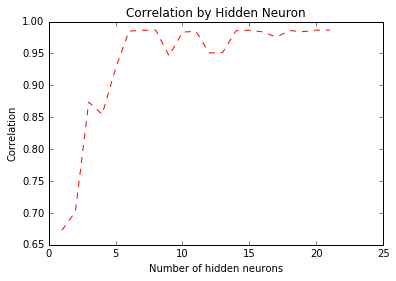

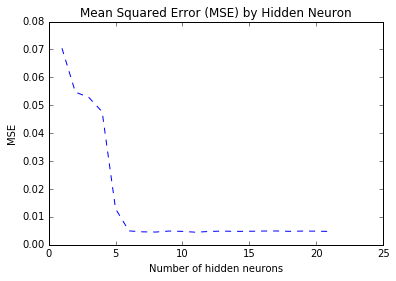

In [86]:
# Correlation by Hidden Neuron
# Исследовать скоррелированность ошибки нейромодели и входных данных,
# чтобы сделать вывод об адекватности построенной модели только при наличии низких корреляций.
# http://www.neuroproject.ru/pre_grap.htm

plt.plot(n_hide, correlation_list, 'r--')
plt.ylabel("Correlation")
plt.xlabel("Number of hidden neurons")
plt.title("Correlation by Hidden Neuron")
plt.show()

plt.plot(n_hide, mse_list, '--')
plt.ylabel("MSE")
plt.xlabel("Number of hidden neurons")
plt.title("Mean Squared Error (MSE) by Hidden Neuron")
plt.show()

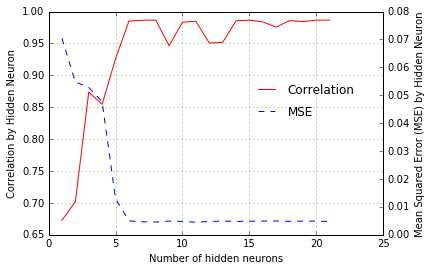

In [97]:
# Plotting on left and right axis using matplotlib
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_hide, correlation_list, 'r-', label = 'Correlation')
ax2 = ax.twinx()
ax2.plot(n_hide, mse_list, '--b', label = 'MSE')
ax.legend(loc = (.6,.6), frameon = False)
ax2.legend( loc = (.6, .5), frameon = False)
ax.grid(color = 'g')
#ax2.grid(color = 'r')
ax.set_xlabel("Number of hidden neurons")
ax.set_ylabel("Correlation by Hidden Neuron")
ax2.set_ylabel("Mean Squared Error (MSE) by Hidden Neuron")
#ax2.set_ylim(0, 35)
#ax.set_ylim(-20,100)
plt.show()
# save the figure
plt.savefig("left_right.png", dpi=72)
#http://pyviy.blogspot.ru/2009/08/matplotlib_21.html

In [88]:
(ann.get_total_neurons(), ann.get_total_connections(),
    ann.get_num_input(), ann.get_num_output(), ann.get_num_layers(),
    ann.get_connection_rate())

(25, 64, 1, 1, 3, 1.0)

In [89]:
run_train = []
for i in range(len(input_data_train)):
    run_train.append(ann_list[9].run([input_data_train[i][0]]))

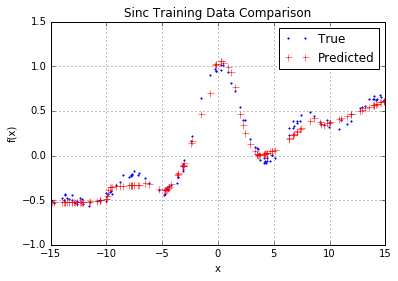

In [90]:
plt.plot(input_data_train, target_data_train, "b.", markersize=3)
plt.plot(input_data_train, run_train, 'r+', markersize=7)
plt.grid()
plt.title("Sinc Training Data Comparison")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.xlim(-15,15)
plt.ylim(-1,1.5)
plt.legend(["True", "Predicted"])

In [91]:
run_test = []
for i in range(len(input_data_test)):
    run_test.append(ann.run([input_data_test[i][0]]))

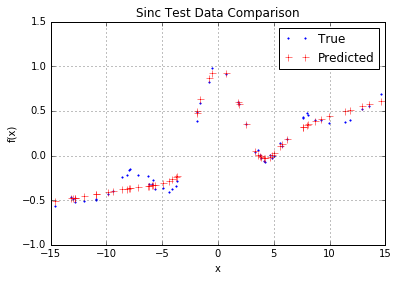

In [92]:
plt.plot(input_data_test, target_data_test, "b.", markersize=3)
plt.plot(input_data_test, run_test, 'r+', markersize=7)
plt.grid()
plt.title("Sinc Test Data Comparison")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.xlim(-15,15)
plt.ylim(-1,1.5)
plt.legend(["True", "Predicted"])

In [93]:
diff_train = []
diff_test = []

for i in range(len(input_data_train)):
    diff_train.append(target_data_train[i][0] - run_train[i][0])
print("diff_train= ", min(diff_train), max(diff_train)) 

for i in range(len(input_data_test)):
    diff_test.append(target_data_test[i][0] - run_test[i][0])
print(min(diff_test), max(diff_test)) 

delta_x_train = np.linspace(min(diff_train), max(diff_train), 21).tolist() #, len(input_data_train))
delta_x_test = np.linspace(min(diff_test), max(diff_test), 21).tolist() #, len(input_data_test)) 

#(delta_x_train, delta_x_test)

diff_train=  -0.12529713814525834 0.2017316186831546
-0.12359766047925697 0.22053648618349314


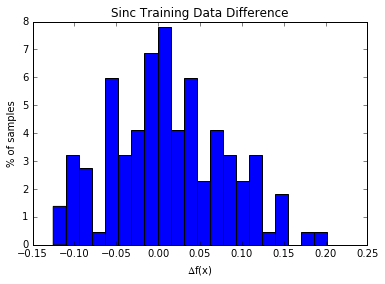

In [94]:
# Formatting & Tweaking Our Histogram
plt.hist(diff_train, bins=21, normed=True) #,  label='Uniform')
plt.title("Sinc Training Data Difference")
plt.ylabel("% of samples")
plt.xlabel("$\Delta f(x)$")
#plt.legend()
#plt.show()
# Сколько процентов составляет число 23 от числа 115 ?
# Нужно: 23*100/115 = 20%

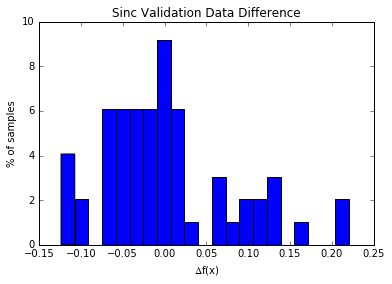

In [95]:
# Formatting & Tweaking Our Histogram
plt.hist(diff_test, bins=21, normed=True) #,  label='Uniform')
plt.title("Sinc Validation Data Difference")
plt.ylabel("% of samples")
plt.xlabel("$\Delta f(x)$")

Tips
--
* NeuralNetTools: Visualization and Analysis Tools for Neural Networks https://cran.r-project.org/web/packages/NeuralNetTools/
* http://feltes.ch/index.php/2015/10/03/classifing-mnist-dataset-with-fast-artificial-neural-network-library-fann-in-python/
* http://arxiv.org/pdf/1309.0790.pdf
* http://koldunov.net/?p=384#more-384
* http://pdfcrowd.com/

* http://matplotlib.org/examples/pylab_examples/multiple_yaxis_with_spines.html multiple_yaxis_with_spines.py
* optimal brain surgery
* http://m.litread.me/read/260071/201000-202000?page=2
* http://www.softcraft.ru/neuro/ni/p12.shtml Лекции 13,14. Контрастер
* http://www.academia.edu/20153168/On_Predicting_the_Optimal_Number_of_Hidden_Nodes On Predicting the Optimal Number of Hidden Nodes
* This is not space science (http://nxn.se/)

In [96]:
'2'+str(3)

'23'